In [124]:
colab='n'
colab_dataset_train='/content/gdrive/MyDrive/Colab Notebooks/ProjectML/train.csv'
colab_dataset_test='/content/gdrive/MyDrive/Colab Notebooks/ProjectML/test.csv'


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import nltk
nltk.download('punkt')
import seaborn as sns
from collections import defaultdict
stop=set(stopwords.words('english'))
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

import time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score,accuracy_score,roc_auc_score


[nltk_data] Downloading package stopwords to C:\Users\Sahil
[nltk_data]     Solanki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sahil
[nltk_data]     Solanki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [126]:

if str.lower(colab)=='y':
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_train=pd.read_csv(colab_dataset_train)
    dataset_test=pd.read_csv(colab_dataset_test)
else:
    dataset_train=pd.read_csv('train.csv')
    dataset_test=pd.read_csv('test.csv')

In [127]:
dataset_test.shape

(3263, 4)

In [128]:
dataset_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [206]:
# Checking dataset data desription like count of rows,mean values etc
print('''
Dataset Description:
''')
print(dataset_train.describe())
# Checking dataset size of data
print('''
Dataset information:
''')
print(dataset_train.info())

#Checking for Number of Na Values 
print('''
Dataset NA column information:
''')
print(dataset_train[dataset_train['text'].isna()==True])


Dataset Description:

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

Dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Dataset NA column information:

Empty DataFrame
Columns: [id, keyword, location, text, target]
Index: []


# EDA(Exploratory Data Analysis)


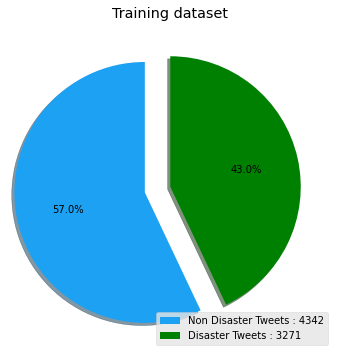

In [210]:
#checking distribution of data across both the labels
num_zeroes=dataset_train['target'][dataset_train['target']==0].count()
num_one=dataset_train['target'][dataset_train['target']==1].count()

x=dataset_train.target.value_counts()
plt.figure(1,figsize=[8,6])
colors=['#1DA1F2','green']
Labels=['Non Disaster Tweets : {}'.format(num_zeroes),'Disaster Tweets : {}'.format(num_one)]
explode=[0.2,0]

plt.pie([num_zeroes,num_one],explode=explode,shadow=True,autopct='%1.1f%%',startangle=90,colors=colors)
plt.title('Training dataset')
plt.legend(Labels,loc='lower right')



There is not major distribution disrepency in data, around 57% of the data belongs to Non Disaster Tweets while 43% belongs to disaster tweets

## Number of Words in Tweets

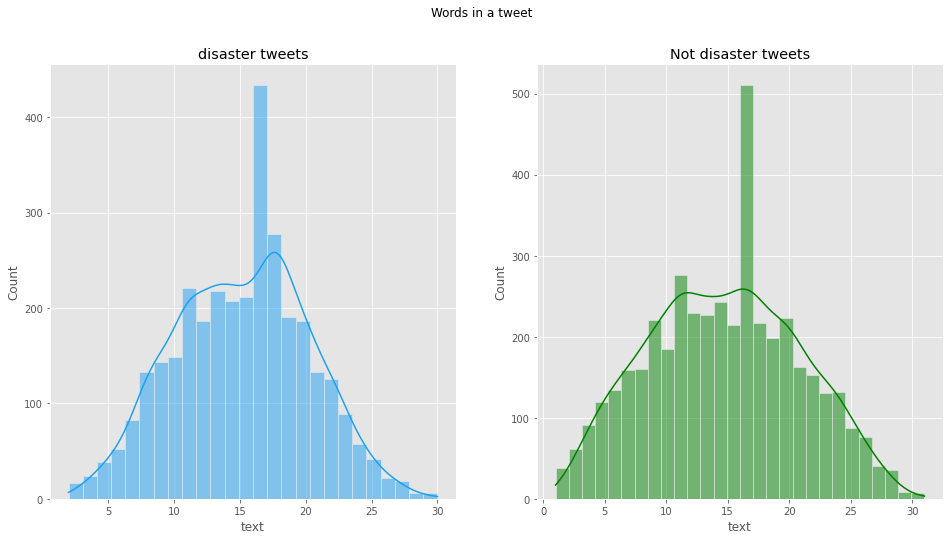

In [131]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
tweet_len=dataset_train[dataset_train['target']==1]['text'].str.split().map(lambda x: len(x))



sns.histplot(data=tweet_len, ax=ax1,kde=True, color='#1DA1F2')
ax1.set_title('disaster tweets')
tweet_len=dataset_train[dataset_train['target']==0]['text'].str.split().map(lambda x: len(x))



sns.histplot(data=tweet_len, ax=ax2, kde=True,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

C:\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

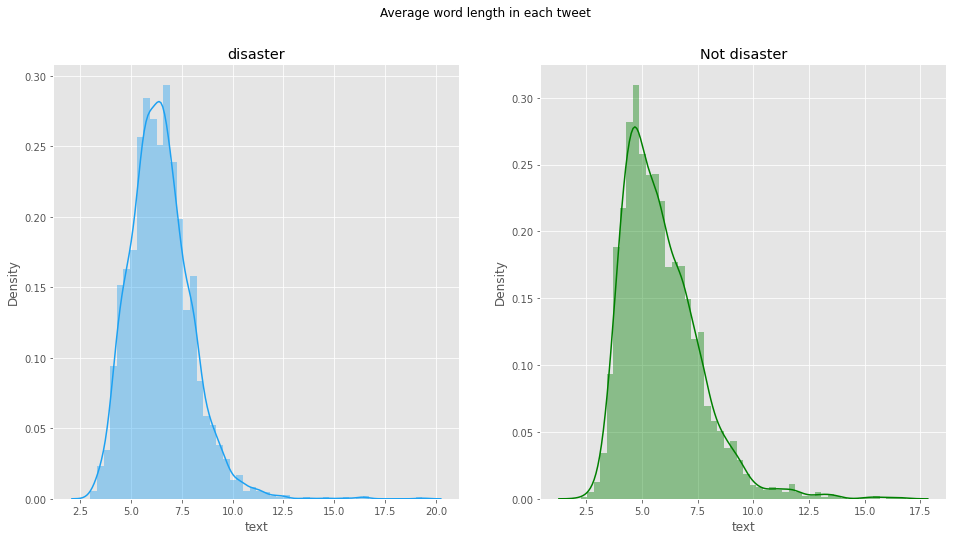

In [132]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
word=dataset_train[dataset_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#1DA1F2')
ax1.set_title('disaster')
word=dataset_train[dataset_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

On an Average there are around 30 words in each Tweet.This information can be further used while setting the max lenght in LSTM

## Number of characters in tweets

We are trying to check the number of characters that are in tweets in both the classes

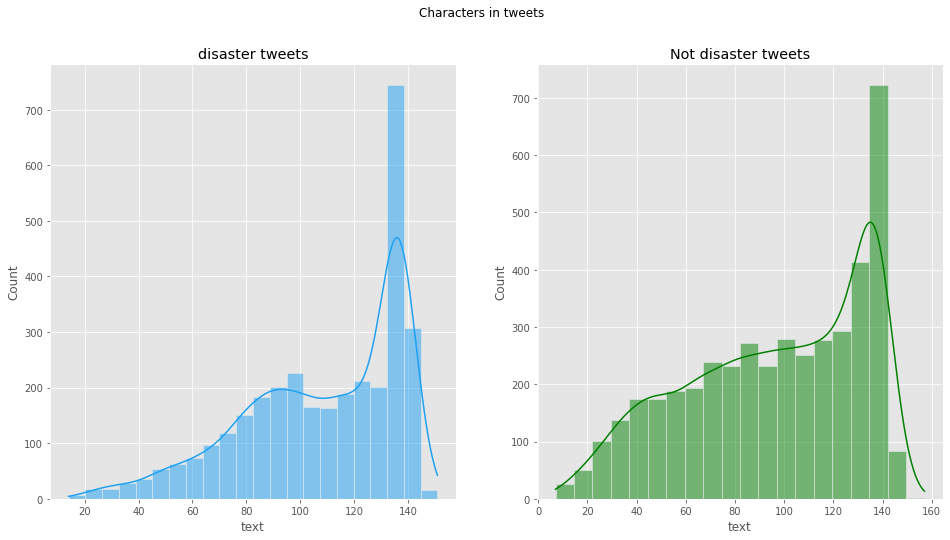

In [133]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
tweet_len=dataset_train[dataset_train['target']==1]['text'].str.len()

sns.histplot(data=tweet_len, ax=ax1, kde=True,color='#1DA1F2')
ax1.set_title('disaster tweets')


tweet_len=dataset_train[dataset_train['target']==0]['text'].str.len()
sns.histplot(data=tweet_len, ax=ax2, kde=True,color='green')

ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [134]:

import re #Importing  regular expression library to check find hashtags in the text data
def get_hashtags(target):
    Tweet=[]
    for i in dataset_train[dataset_train['target']==target]['text']:
        Tweet.append(re.findall(r"#(\w+)",i))

    distincttweet=[]
    for i in Tweet:
        for x in i:
            distincttweet.append(x)
    l=defaultdict(int)
    for x in distincttweet:
        l[x]+=1
    print(type(l))
    return l,Tweet




In [135]:
distincttweet0,tweet0=get_hashtags(0)
distincttweet1,tweet1=get_hashtags(1)

common_tweets=[]

for x in distincttweet1:
    for y in distincttweet0:
        if x==y:
            common_tweets.append(x)




<class 'collections.defaultdict'>
<class 'collections.defaultdict'>


In [136]:

pd.set_option('display.width', 10000)
common_tweets_1=[]
for i in range(0,len(common_tweets)):
    common_tweets_1.append(dataset_train[['text','target']][dataset_train['text'].str.find('#{}'.format(common_tweets[i]))!=-1])


## Identifying the common stop words in the **tweets**

Stopwords are words like “a”, “the”, “to”, “and”, “of”, “in” etc. which are used very frequently in a sentence but these words do not add much meaning to the sentence.

C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

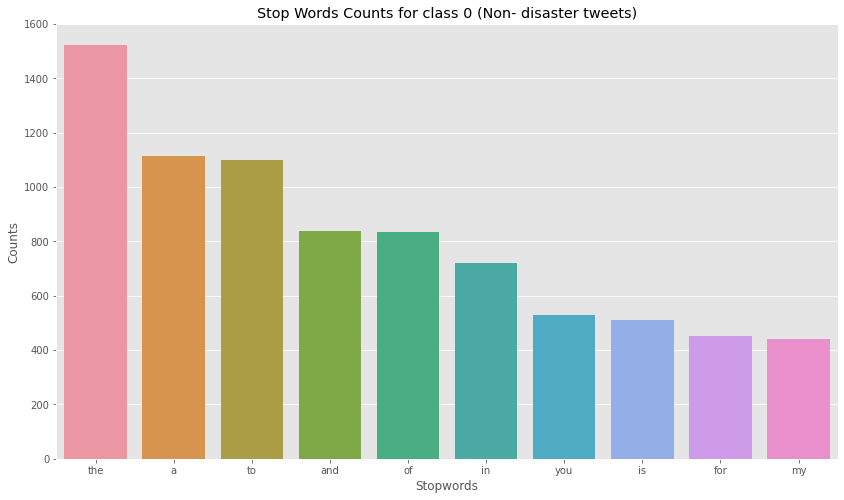

In [137]:
def create_corpus(target):
    corpus=[]
    
    for x in dataset_train[dataset_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# First we will analyze common stopwords in tweets with class 0.

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

# plotting the Graph

x,y=zip(*top)
#plt.bar(x,y)
x = np.array(x)
y = np.array(y) 

plt.figure(figsize = (14,8))
sns.set_palette(sns.color_palette("icefire"))
ax = sns.barplot(x,y)
ax.set_title("Stop Words Counts for class 0 (Non- disaster tweets)")
ax.set_xlabel("Stopwords")
ax.set_ylabel("Counts")




C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

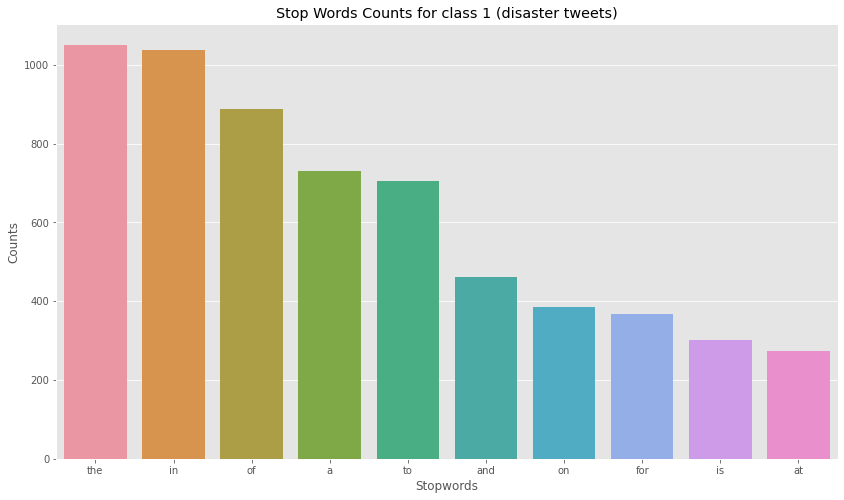

In [138]:
# Second we will analyze common stopwords in tweets with class 1.

corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

# plotting the Graph

x,y=zip(*top)
x = np.array(x)
y = np.array(y) 

plt.figure(figsize = (14,8))
sns.set_palette(sns.color_palette("icefire"))
ax = sns.barplot(x,y)
ax.set_title("Stop Words Counts for class 1 (disaster tweets)")
ax.set_xlabel("Stopwords")
ax.set_ylabel("Counts")


Most Used stopword in both the classes is "the"

## Checking Punctuations

C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

<Figure size 720x360 with 0 Axes>

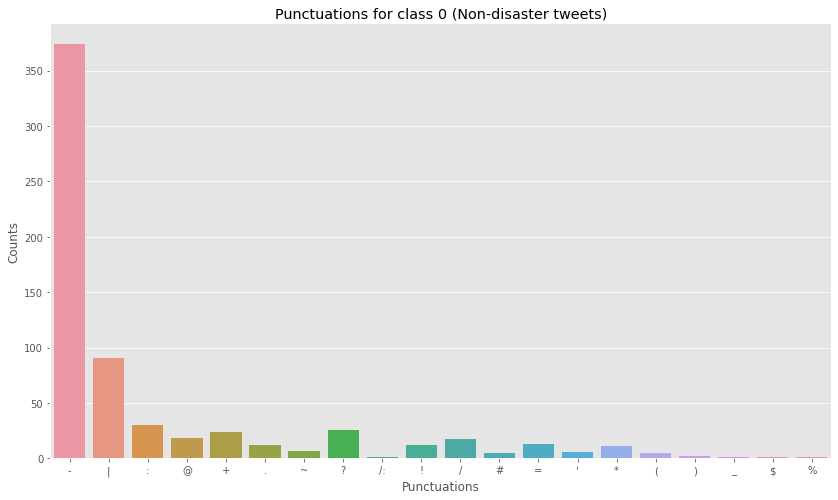

In [139]:
# Punctuations for class 0

plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())

x = np.array(x)
y = np.array(y) 

plt.figure(figsize = (14,8))
sns.set_palette(sns.color_palette("icefire"))
ax = sns.barplot(x,y)
ax.set_title("Punctuations for class 0 (Non-disaster tweets)")
ax.set_xlabel("Punctuations")
ax.set_ylabel("Counts")


C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

<Figure size 720x360 with 0 Axes>

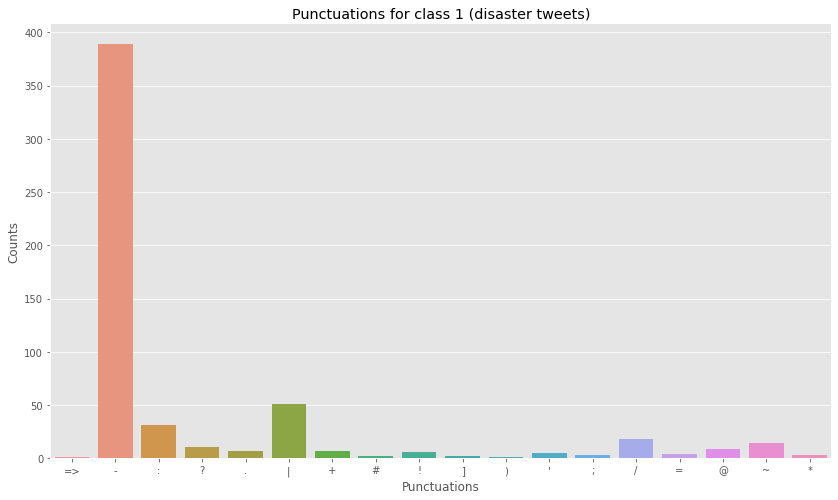

In [140]:
# Punctuations for class 1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())

x = np.array(x)
y = np.array(y) 

plt.figure(figsize = (14,8))
sns.set_palette(sns.color_palette("icefire"))
ax = sns.barplot(x,y)
ax.set_title("Punctuations for class 1 (disaster tweets)")
ax.set_xlabel("Punctuations")
ax.set_ylabel("Counts")

The Most Used punctuation in both the classes is '-'

## Checking for Common Words

Text(0, 0.5, 'Common Words')

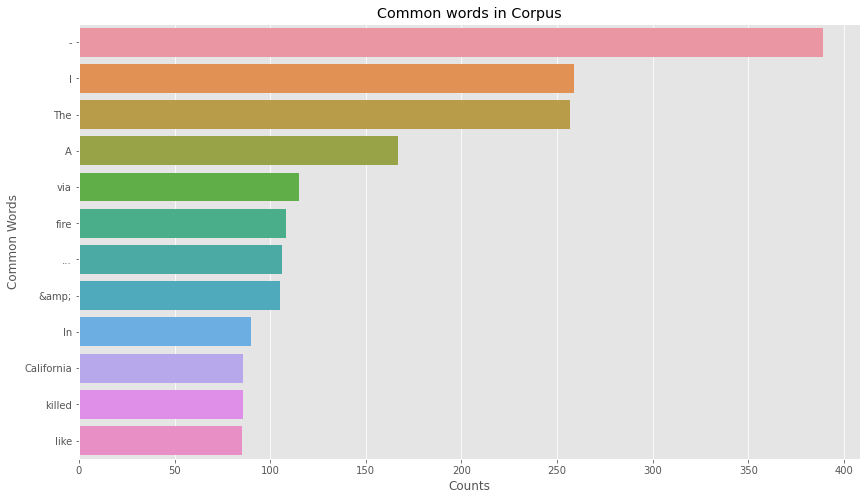

In [141]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

#plotting the graph
plt.figure(figsize = (14,8))
ax = sns.barplot(x=y,y=x)
ax.set_title("Common words in Corpus")
ax.set_xlabel("Counts")
ax.set_ylabel("Common Words")

I and - has the highest count for common words used in tweets.

## N-gram Analysis

In a document, N-grams are continuous sequences of words, symbols, or tokens.Normally in case of Natural Language processing we use bi-gram or a tri-gram. In this step we are checking for bi-gram.

In [142]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0, 0.5, 'Bi-Grams')

<Figure size 720x360 with 0 Axes>

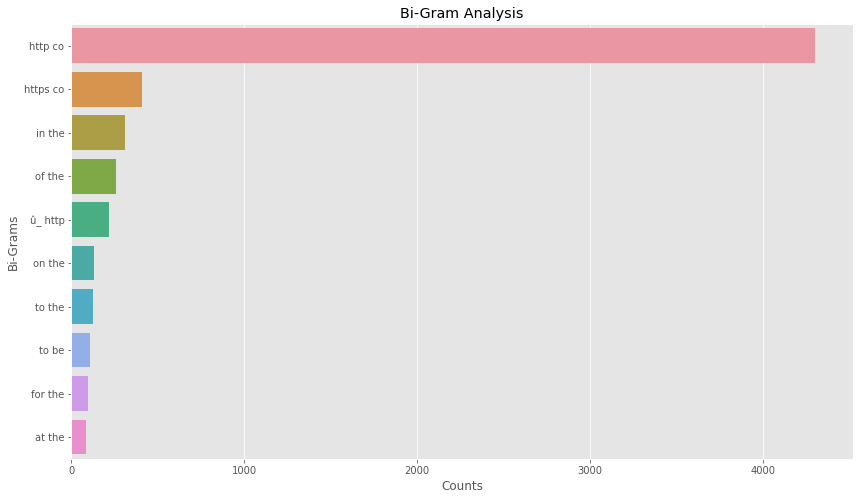

In [145]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(dataset_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))


plt.figure(figsize = (14,8))
ax = sns.barplot(x=y,y=x)
ax.set_title("Bi-Gram Analysis")
ax.set_xlabel("Counts")
ax.set_ylabel("Bi-Grams")

The Bi-gram "http co" has the highest count. "http co" has no meaning. Hence we can remove this bigram as part of our pre-processing.


# Data Pre-Processing

After exploring the data we are well aware of how our data looks like and what all can we remove from the text as part of our cleaning process e.g. we can remove wild characters(#,@),punctuations,emojis etc.

In [146]:
df =dataset_train
df.shape

(7613, 5)

## Removing URLs

In [147]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))


In [148]:
df=df.fillna('')
df['location']=df['location'].apply(lambda x : remove_URL(x))
df['keyword']=df['keyword'].apply(lambda x : remove_URL(x))

## Removing HTML tags

In [149]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


df['text']=df['text'].apply(lambda x : remove_html(x))
df['location']=df['location'].apply(lambda x : remove_html(x))
df['keyword']=df['keyword'].apply(lambda x : remove_html(x))

## Removing Emojis

In [150]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df['text']=df['text'].apply(lambda x: remove_emoji(x))
df['location']=df['location'].apply(lambda x: remove_emoji(x))
df['keyword']=df['keyword'].apply(lambda x: remove_emoji(x))

## Removing Punctuations

In [151]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))
df['location']=df['location'].apply(lambda x : remove_punct(x))
df['keyword']=df['keyword'].apply(lambda x : remove_punct(x))

## Removing stop words

In [152]:
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no", "dont","do","don't"]
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

df['text']=df['text'].apply(lambda x : remove_punct(x))
df['location']=df['location'].apply(lambda x : remove_punct(x))
df['keyword']=df['keyword'].apply(lambda x : remove_punct(x))

## Spelling Correction with python library

We are using 'pyspellchecker' library for this step which help us identify correct spelling of words

In [153]:
%pip install pyspellchecker

You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [154]:
from spellchecker import SpellChecker

In [155]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [156]:
df['text']=df['text'].apply(lambda x : correct_spellings(x))  ## Execution time = 25 m 17 s

# Feature Generation

As part of this step we are planning to utilise the location column to generate more feature so that we can create more relationships between the classes (disaster and non disaster)

In [158]:
#using the library spacy 
!pip install -U spacy
# !python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg

You should consider upgrading via the 'c:\python\python39\python.exe -m pip install --upgrade pip' command.


2022-04-14 02:30:17.446377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-14 02:30:17.447000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.



✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [159]:
import spacy
nlp = spacy.load('en_core_web_lg')

Spacy has an extremely fast statistical entity recognition system which can identify whether the provided text is a “real-world object” that’s an assigned name e.g. a person, a country, a product or a book title. With the help of this we are converting nulls or any value which is not a noun to '0' in a new feature 


In [160]:
def location_detection(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append(ent)
    if len(entities)>0:
        return 1
    return 0

In [161]:
df['original_locations'] = df['location'].apply(lambda x: location_detection(x))


We can usee in the data as part of location there have been words used like "somewhere","nowhere","world" etc. which donot specifically tells us about any location. In an ideal world we are assuming in a real disaster tweet the location would not be populated with similar words. Hence if are generating a new feature which highlights similar scenarios.

In [162]:
invalid_locations = ['place','room','home','somewhere','nowhere','everywhere','location',
                  'dope','kidding','moon','wherever','dimension','world','fvck','fuck','beside']
def is_location_invalid(text):
    for word in invalid_locations:
        if word in text:
            return 1
    return 0
df['Is_location_invalid'] = df['location'].apply(lambda x: is_location_invalid(x))

In this step we are trying to find the the words which are most frequently used exlusively in in class of tweets.e.g. one of the words very frequently and exclusively used in disaster tweets is ‘ambulance'. With this we are creating a new feature which highlight these words and a relationship cab be maintained between the tweet and the class witht he help of similar word. As in this case if the word is ambulance it is highly likely that the tweet is a disaster tweet.<br>

In below steps we are finding the 400 most frequently used words in both the classes and are then with the help of sets finding out words exclusive to just one class

In [163]:
import nltk
nltk.download('punkt')
def return_top_words(text,words = 10):#Finding out the most frequent words used
    allWords = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)    
    mostCommontuples= allWordExceptStopDist.most_common(words)
    mostCommon = [tupl[0] for tupl in mostCommontuples]
    return mostCommon

[nltk_data] Downloading package punkt to C:\Users\Sahil
[nltk_data]     Solanki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [164]:
disaster_tweets =' '.join(df[df['target'] == 1]['text'].tolist())
non_disaster_tweets = ' '.join(df[df['target'] == 0]['text'].tolist())

top_400_disaster_words = return_top_words(disaster_tweets,400)
top_400_nondisaster_words = return_top_words(non_disaster_tweets,400)
top_disaster_exclusive = list(set(top_400_disaster_words).difference(set(top_400_nondisaster_words)))
top_nondisaster_exclusive = list(set(top_400_nondisaster_words).difference(set(top_400_disaster_words)))

total_vocab = top_disaster_exclusive + top_nondisaster_exclusive

In [165]:
for word in total_vocab:
    df['Is_'+word+'_present'] = df['text'].apply(lambda x: (word in x)*1)
    df['Is_'+word+'_present'] = df['text'].apply(lambda x: (word in x)*1)

C:\Users\SAHILS~1\AppData\Local\Temp/ipykernel_22008/3247362257.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Is_'+word+'_present'] = df['text'].apply(lambda x: (word in x)*1)


## Vectorization with the help of TFIDF

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         max_features = 5000,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(df['text'])
X_test_tfidf = tf_idf.transform(df['text'])
tf_kw = TfidfVectorizer(ngram_range = (1,2),
                        binary = True,
                        max_features = 1500,
                        smooth_idf = False)
kw_train_tfidf = tf_kw.fit_transform(df['keyword'])
kw_test_tfidf = tf_kw.transform(df['keyword'])
tf_location = TfidfVectorizer(ngram_range = (1,2),
                              binary = True,
                              max_features = 1500,
                              smooth_idf = False)
location_train_tfidf = tf_location.fit_transform(df['location'])
location_test_tfidf = tf_location.transform(df['location'])

In [167]:
df = df.reset_index(drop=True)
df = pd.concat([df,pd.DataFrame(X_train_tfidf.toarray(),
                                                columns = ['text_contains_'+ str(text) for text in tf_idf.get_feature_names()]),
                        pd.DataFrame(kw_train_tfidf.toarray(),
                                     columns = ['keyword_contains_'+str(text) for text in tf_kw.get_feature_names()]),
                        pd.DataFrame(location_train_tfidf.toarray(),
                                     columns = ['location_contains_'+str(text) for text in tf_location.get_feature_names()])],axis = 1)

C:\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [168]:
def create_vec(dataframe):
    texts = dataframe['text'].tolist()
    vectors = []
    for doc in nlp.pipe(texts):
        vectors.append(list(doc.vector))
    df = pd.DataFrame(vectors,columns = ['vec_'+str(i) for i in range(300)])
    return df
vec_train = create_vec(df)
df = pd.concat([df,vec_train],axis = 1)


In [169]:
train_data = df.drop(['keyword','location','text'],axis = 1)

In [170]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,y_test=train_test_split(train_data.drop('target',axis = 1),train_data['target'],test_size=0.20)

# MODELS

## RANDOM FOREST

In [ ]:
# with the help of grid search we are trying to look for the best possible parameter values
max_depth=[2,8,16]
n_estimators = [64,128,256]
max_features=[2,3]

param_grid = dict(max_depth=max_depth, 
                  n_estimators=n_estimators,
                  max_features=max_features)

dfrst = RandomForestClassifier(n_estimators=n_estimators,
                               max_depth=max_depth,
                               max_features=max_features)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 3)
grid_results = grid.fit(X_train, Y_train)

# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(X_test)
print('Best results:{} '.format(best_clf))

Best results:RandomForestClassifier(max_depth=16, max_features=3, n_estimators=64) 


In [50]:
#Running Random forest with best parameters to get time trained on best parameters 
forest = RandomForestClassifier(n_estimators=best_clf.n_estimators,max_depth=best_clf.max_depth,max_features=best_clf.max_features)
training_start=time.perf_counter()
forest.fit(X_train,Y_train)
training_end=time.perf_counter()


prediction_start=time.perf_counter()
Y_pred_train = forest.predict(X_test)
prediction_end=time.perf_counter()

forest_training_time=training_end-training_start
forest_prediction_time=prediction_end-prediction_start

print(classification_report(y_test,Y_pred_train))

print("Time consumed for training: %4.3f seconds" % (forest_training_time))
print("Time consumed for prediction: %6.5f seconds" % (forest_prediction_time))

C:\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.74      0.78       894
           1       0.68      0.79      0.73       629

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.76      0.76      1523

Time consumed for training: 35.660 seconds
Time consumed for prediction: 0.34328 seconds


### AUC CURVE

Random Forest
false positive:[0.         0.25950783 1.        ]   , true positive :[0.         0.78696343 1.        ] 
AUC:0.7637278020223145


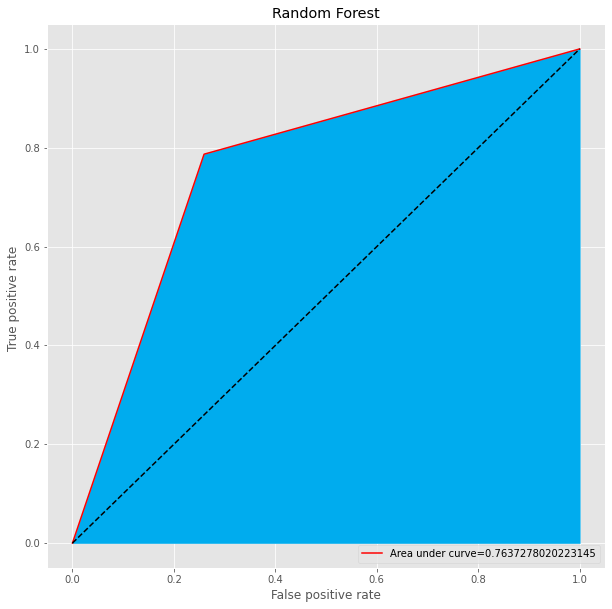

In [84]:

print('Random Forest')
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_train)
print('false positive:{}   , true positive :{} '.format(fpr,tpr))
plt.figure(1,figsize=[10,10])
plt.fill_between(fpr,tpr,color='#00ACEE')
auc = metrics.roc_auc_score(y_test, Y_pred_train)
plt.plot(fpr,tpr,label="Area under curve={}".format(auc),c='red')
plt.plot(fpr,fpr,linestyle='dashed',c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
plt.title('Random Forest')
plt.legend(loc='lower right')
# plt.legend('Auc Score:{}'.format(auc))
print("AUC:{}".format(auc))

Text(51.0, 0.5, 'True label')

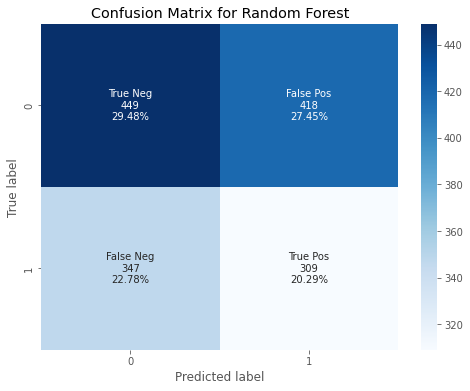

In [192]:
#confusion Matrix for Random Forest
cm=confusion_matrix(y_test,Y_pred_train)
plt.figure(figsize = (8,6))
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

ax.set_title("Confusion Matrix for Random Forest")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

## SVC

In [ ]:

rf_params = {
    'C': [10, 100],
    "kernel":['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(X_train,Y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_)
)

In [188]:
# best_svc = grid.best_estimator_
# classifier_svc=SVC(C=best_svc.C,kernel=best_svc.kernel)
from sklearn.svm import SVC
classifier_svc=SVC()
training_start=time.perf_counter()
classifier_svc.fit(X_train,Y_train)
training_end=time.perf_counter()

prediction_start = time.perf_counter()
y_predSVC=classifier_svc.predict(X_test)
prediction_end = time.perf_counter()

svc_training_time=training_end-training_start
svc_predcition_time=prediction_end-prediction_start

print(classification_report(y_test,y_predSVC))

print("Time consumed for training: %4.3f seconds" % (svc_training_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_predcition_time))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       867
           1       0.00      0.00      0.00       656

    accuracy                           0.57      1523
   macro avg       0.28      0.50      0.36      1523
weighted avg       0.32      0.57      0.41      1523

Time consumed for training: 177.325 seconds
Time consumed for prediction: 67.33109 seconds


C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### AUC Curve

SVC
false positive:[0. 1.]   , true positive :[0. 1.] 
AUC:0.5


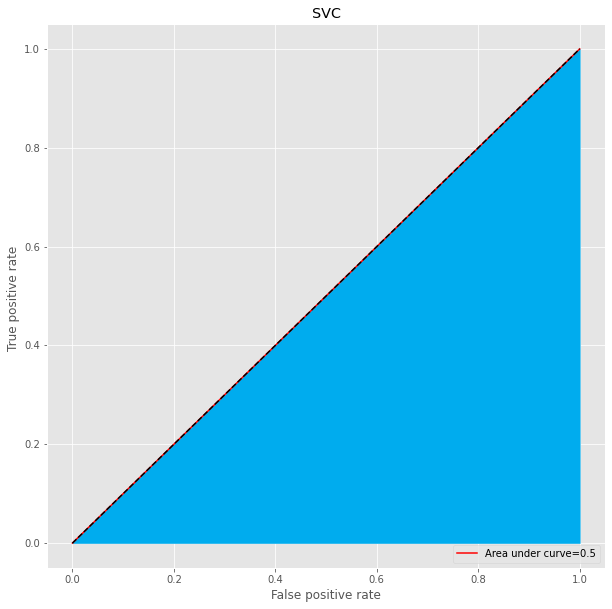

In [189]:

print('SVC')
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predSVC)
print('false positive:{}   , true positive :{} '.format(fpr,tpr))
plt.figure(1,figsize=[10,10])
plt.fill_between(fpr,tpr,color='#00ACEE')
auc = metrics.roc_auc_score(y_test, y_predSVC)
plt.plot(fpr,tpr,label="Area under curve={}".format(auc),c='red')
plt.plot(fpr,fpr,linestyle='dashed',c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
plt.title('SVC')
plt.legend(loc='lower right')
# plt.legend('Auc Score:{}'.format(auc))
print("AUC:{}".format(auc))

### Confusion Matrix

Text(51.0, 0.5, 'True label')

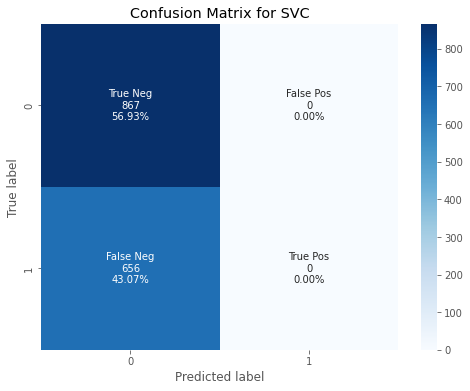

In [191]:
#confusion Matrix for SVC
cm=confusion_matrix(y_test,y_predSVC)
plt.figure(figsize = (8,6))
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

ax.set_title("Confusion Matrix for SVC")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

## XGBOOST

In [48]:
#HYpertuning the XGBOOST with the help of Gridsearchcv
import time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
max_depth=[5,10]
n_estimators = [128, 200]
# eval_metric=['mlogloss']
# use_label_encoder=[False]

# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,gamma=gamma,eval_metric=eval_metric,use_label_encoder=use_label_encoder)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
XGB = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(XGB,param_grid, cv = 3)
grid_results = grid.fit(X_train, Y_train)

# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(X_test)

In [49]:
print(best_clf)

XGBClassifier(max_depth=5, n_estimators=200)


In [185]:
#Running XGBOOST with best parameters to get time trained on best parameters 
xgb = XGBClassifier(n_estimators=best_clf.n_estimators,learning_rate = 0.2,max_depth = best_clf.max_depth)

training_start = time.perf_counter()
xgb.fit(X_train, Y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
pred_final = xgb.predict(X_test)
print(classification_report(y_test,pred_final))
prediction_end = time.perf_counter()
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

C:\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       867
           1       0.80      0.71      0.76       656

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Time consumed for training: 139.199
Time consumed for prediction: 0.81338 seconds


### AUC Curve

XGBOOST
false positive:[0.         0.04036909 1.        ]   , true positive :[0.     0.9375 1.    ] 
AUC:0.9485654555940023


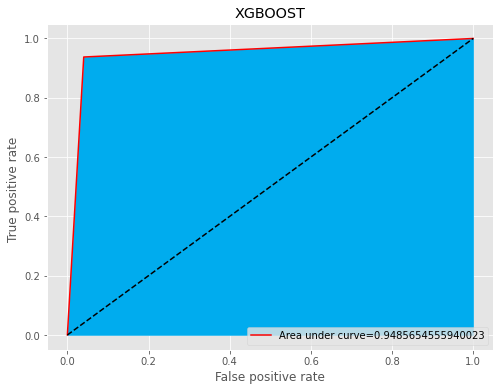

In [174]:

print('XGBOOST')
fpr, tpr, _ = metrics.roc_curve(y_test,  pred_final)
print('false positive:{}   , true positive :{} '.format(fpr,tpr))
plt.figure(1,figsize=[8,6])
plt.fill_between(fpr,tpr,color='#00ACEE')
auc = metrics.roc_auc_score(y_test, pred_final)
plt.plot(fpr,tpr,label="Area under curve={}".format(auc),c='red')
plt.plot(fpr,fpr,linestyle='dashed',c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
plt.title('XGBOOST')
plt.legend(loc='lower right')
print("AUC:{}".format(auc))

### Confusion Matrix

Text(51.0, 0.5, 'True label')

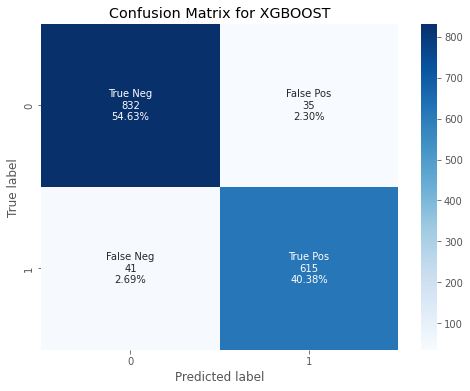

In [175]:

cm=confusion_matrix(y_test,pred_final)
plt.figure(figsize = (8,6))
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

ax.set_title("Confusion Matrix for XGBOOST")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

## ANN-Feed Forward Neueral Network

In [180]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

modelNN=tf.keras.Sequential([
      Dense(4000,input_shape=(X_train.shape[1],)),
      Dense(2000),
      Dense(100),
      Dense(50),
      Dense(1,activation='sigmoid')
                            ])
modelNN.compile(optimizer='Adam',loss='binary_crossentropy',metrics=["accuracy"])
training_start=time.perf_counter()
modelNN.fit(X_train,Y_train,epochs=15)
training_end=time.perf_counter()

modelNN_training_time=training_end-training_start

prediction_start=time.perf_counter()
y_predict_NN=modelNN.predict(X_test)
prediction_end=time.perf_counter()

modelNN_prediction_time=prediction_end-prediction_start

y_predict_NN[y_predict_NN<0.5]=0
y_predict_NN[y_predict_NN>=0.5]=1

print(classification_report(y_test,y_predict_NN))

print("Time consumed for training: %4.3f seconds" % (modelNN_training_time))
print("Time consumed for prediction: %6.5f seconds" % (modelNN_prediction_time))

Epoch 1/15
191/191 [==============================] - 40s 203ms/step - loss: 215.2744 - accuracy: 0.5516
Epoch 2/15
191/191 [==============================] - 40s 208ms/step - loss: 0.7105 - accuracy: 0.6882
Epoch 3/15
191/191 [==============================] - 36s 189ms/step - loss: 0.5373 - accuracy: 0.7522s - loss: 0.534
Epoch 4/15
191/191 [==============================] - 35s 181ms/step - loss: 0.4820 - accuracy: 0.7829
Epoch 5/15
191/191 [==============================] - 34s 178ms/step - loss: 0.4828 - accuracy: 0.7813
Epoch 6/15
191/191 [==============================] - 34s 177ms/step - loss: 0.4698 - accuracy: 0.7905
Epoch 7/15
191/191 [==============================] - 34s 181ms/step - loss: 0.4319 - accuracy: 0.8092
Epoch 8/15
191/191 [==============================] - 34s 179ms/step - loss: 0.4044 - accuracy: 0.8213
Epoch 9/15
191/191 [==============================] - 36s 189ms/step - loss: 0.3807 - accuracy: 0.8424s - loss: 0.3755 - accuracy - ETA: 2s
Epoch 10/15
191/191

In [181]:
modelNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 4000)              30116000  
                                                                 
 dense_17 (Dense)            (None, 2000)              8002000   
                                                                 
 dense_18 (Dense)            (None, 100)               200100    
                                                                 
 dense_19 (Dense)            (None, 50)                5050      
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 38,323,201
Trainable params: 38,323,201
Non-trainable params: 0
_________________________________________________________________


### AUC Curve

ANN:Feed Forward Network
false positive:[0.         0.37139562 1.        ]   , true positive :[0.         0.87804878 1.        ] 
AUC:0.7533265817087236


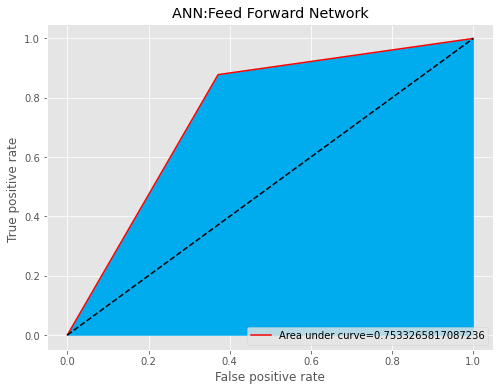

In [182]:
#AUC Curve
print('ANN:Feed Forward Network')
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict_NN)
print('false positive:{}   , true positive :{} '.format(fpr,tpr))
plt.figure(1,figsize=[8,6])
plt.fill_between(fpr,tpr,color='#00ACEE')
auc = metrics.roc_auc_score(y_test, y_predict_NN)
plt.plot(fpr,tpr,label="Area under curve={}".format(auc),c='red')
plt.plot(fpr,fpr,linestyle='dashed',c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
plt.title('ANN:Feed Forward Network')
plt.legend(loc='lower right')
print("AUC:{}".format(auc))


### Confusion Matrix

Text(51.0, 0.5, 'True label')

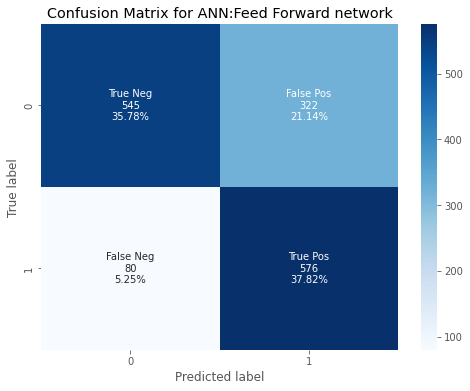

In [183]:
#confusion Matrix for ANN:Feed Forward network
cm=confusion_matrix(y_test,y_predict_NN)
plt.figure(figsize = (8,6))
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

ax.set_title("Confusion Matrix for ANN:Feed Forward network")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

## LSTM

### Tuning Data for LSTM

In [86]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [87]:
corpus=create_corpus(df)

100%|██████████| 7613/7613 [00:01<00:00, 7209.71it/s]


In [88]:
if str.lower(colab)=='y':
    input_path = "/content/gdrive/MyDrive/Colab Notebooks/ProjectML/glove.twitter.27B.100d.txt"
else:
    input_path = "glove.twitter.27B.100d.txt"
emb_dict = {}
glove = open(input_path,encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [89]:
MAX_LEN=30
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [90]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 16230


In [91]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=emb_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16230/16230 [00:00<00:00, 368846.40it/s]


In [92]:
tweet_pad[dataset_train.shape[0]:].shape

(0, 30)

In [93]:
train=tweet_pad[:dataset_train.shape[0]]
test=tweet_pad[dataset_train.shape[0]:]

In [94]:
X_train,X_test,y_train,y_test=train_test_split(train,dataset_train['target'].values,test_size=0.20)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 30)
Shape of Validation  (1523, 30)


### Training LSTM

In [95]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1623100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,665,405
Trainable params: 42,305
Non-trainable params: 1,623,100
_________________________________________________________________


In [98]:
#fitting training data on LSTM
training_start=time.perf_counter()
history=model.fit(X_train,y_train,batch_size=4,epochs=30,validation_data=(X_test,y_test),verbose=2)
training_end=time.perf_counter()

LSTM_training_time=training_end-training_start

Epoch 1/30
1523/1523 - 27s - loss: 0.4806 - accuracy: 0.7796 - val_loss: 0.4673 - val_accuracy: 0.7794 - 27s/epoch - 17ms/step
Epoch 2/30
1523/1523 - 28s - loss: 0.4764 - accuracy: 0.7831 - val_loss: 0.4651 - val_accuracy: 0.7794 - 28s/epoch - 18ms/step
Epoch 3/30
1523/1523 - 27s - loss: 0.4754 - accuracy: 0.7851 - val_loss: 0.4618 - val_accuracy: 0.7840 - 27s/epoch - 17ms/step
Epoch 4/30
1523/1523 - 28s - loss: 0.4671 - accuracy: 0.7931 - val_loss: 0.4603 - val_accuracy: 0.7899 - 28s/epoch - 18ms/step
Epoch 5/30
1523/1523 - 26s - loss: 0.4695 - accuracy: 0.7892 - val_loss: 0.4568 - val_accuracy: 0.7919 - 26s/epoch - 17ms/step
Epoch 6/30
1523/1523 - 26s - loss: 0.4614 - accuracy: 0.7939 - val_loss: 0.4566 - val_accuracy: 0.7905 - 26s/epoch - 17ms/step
Epoch 7/30
1523/1523 - 28s - loss: 0.4661 - accuracy: 0.7911 - val_loss: 0.4545 - val_accuracy: 0.7925 - 28s/epoch - 18ms/step
Epoch 8/30
1523/1523 - 28s - loss: 0.4596 - accuracy: 0.7959 - val_loss: 0.4545 - val_accuracy: 0.7919 - 28s/ep

In [99]:
from sklearn.base import ClassifierMixin
prediction_start=time.perf_counter()
y_predict_LSTM=model.predict(X_test)
y_predict_LSTM[y_predict_LSTM<0.5]=0
y_predict_LSTM[y_predict_LSTM>=0.5]=1
prediction_end=time.perf_counter()

LSTM_prediction_time=prediction_end-prediction_start

print(classification_report(y_test,y_predict_LSTM))


print("Time consumed for training: %4.3f seconds" % (LSTM_training_time))
print("Time consumed for prediction: %6.5f seconds" % (LSTM_prediction_time))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       878
           1       0.78      0.73      0.76       645

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523

Time consumed for training: 794.929 seconds
Time consumed for prediction: 0.76998 seconds


#### AUC Curve

LSTM
false positive:[0.         0.14806378 1.        ]   , true positive :[0.         0.73488372 1.        ] 
AUC:0.793409969804524


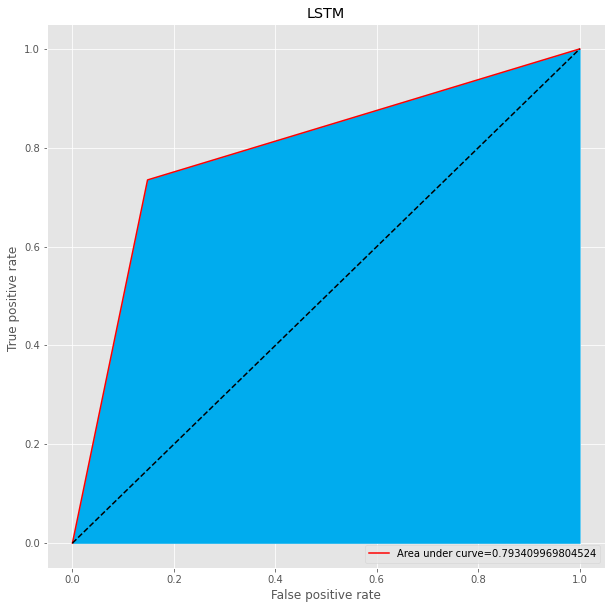

In [100]:
#AUC Curve
print('LSTM')
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict_LSTM)
print('false positive:{}   , true positive :{} '.format(fpr,tpr))
plt.figure(1,figsize=[10,10])
plt.fill_between(fpr,tpr,color='#00ACEE')
auc = metrics.roc_auc_score(y_test, y_predict_LSTM)
plt.plot(fpr,tpr,label="Area under curve={}".format(auc),c='red')
plt.plot(fpr,fpr,linestyle='dashed',c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
plt.title('LSTM')
plt.legend(loc='lower right')
print("AUC:{}".format(auc))

#### Confusion Matrix

Text(51.0, 0.5, 'True label')

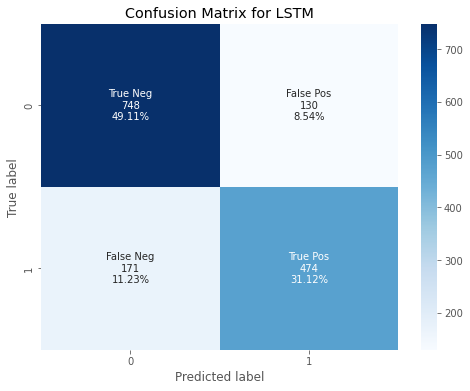

In [101]:
#confusion Matrix for LSTM
cm=confusion_matrix(y_test,y_predict_LSTM)
plt.figure(figsize = (8,6))
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

ax.set_title("Confusion Matrix for LSTM")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")


# Final Conclusion

After performing hyperparameter optimization we have seen that <b>XG-boost</b> still works better and gives better scores in accuracy and f1–score, LSTM also gives good score in accuracy and f1-score but the training time is much larger than XG-boost. So we have selected XG-boost as the final model.<br>


Evaluation metrics with hyper parameter tuning:
				
|Model|	F1-Score|	Accuracy|	Auc Score|	Training Time(sec)|
|-----|---------|-----------|------------|--------------------|
|RFC|	0.78|	0.76|	0.76|	35.66|
|SVC|	0.73|	0.57|	0.5|	177.33|
|XG-Boost|	0.83|	0.8|	0.94|	139.20|
|ANN|	0.74|	0.74|	0.75|	552.32|
|LSTM|	0.76|	0.8|	0.79|	794.93|
